# Data collection

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
df=pd.read_csv("labeledTrainData.tsv",sep="\t")

df.columns=["i","category","content"]

df=df.dropna(subset=["category","content"])

from nltk import word_tokenize     ##tokenize words according to spaces


df["category"].value_counts()

num_classes = len(df["category"].unique())

In [3]:
df

,i,category,content
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...
...,...,...,...
24995,3453_3,0,It seems like more consideration has gone into...
24996,5064_1,0,I don't believe they made this film. Completel...
24997,10905_3,0,"Guy is a loser. Can't get girls, needs to buil..."
24998,10194_3,0,This 30 minute documentary Buñuel made in the ...


# Tokenize：

In [4]:
import jieba
sentence=[i.split(" ") for i in df["content"]]

In [5]:
sentence[1]

['\\The',
 'Classic',
 'War',
 'of',
 'the',
 'Worlds\\"',
 'by',
 'Timothy',
 'Hines',
 'is',
 'a',
 'very',
 'entertaining',
 'film',
 'that',
 'obviously',
 'goes',
 'to',
 'great',
 'effort',
 'and',
 'lengths',
 'to',
 'faithfully',
 'recreate',
 'H.',
 'G.',
 "Wells'",
 'classic',
 'book.',
 'Mr.',
 'Hines',
 'succeeds',
 'in',
 'doing',
 'so.',
 'I,',
 'and',
 'those',
 'who',
 'watched',
 'his',
 'film',
 'with',
 'me,',
 'appreciated',
 'the',
 'fact',
 'that',
 'it',
 'was',
 'not',
 'the',
 'standard,',
 'predictable',
 'Hollywood',
 'fare',
 'that',
 'comes',
 'out',
 'every',
 'year,',
 'e.g.',
 'the',
 'Spielberg',
 'version',
 'with',
 'Tom',
 'Cruise',
 'that',
 'had',
 'only',
 'the',
 'slightest',
 'resemblance',
 'to',
 'the',
 'book.',
 'Obviously,',
 'everyone',
 'looks',
 'for',
 'different',
 'things',
 'in',
 'a',
 'movie.',
 'Those',
 'who',
 'envision',
 'themselves',
 'as',
 'amateur',
 '\\"critics\\"',
 'look',
 'only',
 'to',
 'criticize',
 'everything',
 '

# Training word embedding with embedding size 128 and 10 epochs


In [6]:
import pandas as pd
import gensim
# w2v_model = gensim.models.Word2Vec(sentence, size=128, iter=10, min_count=0)
# word_vectors = w2v_model.wv
# w2v_model.save("w2v")
#w2v_model=gensim.models.Word2Vec.load("GoogleNews-vectors-negative300.bin")
w2v_model=gensim.models.Word2Vec.load("w2v")
#w2v_model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)

In [7]:
from keras.layers import *
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.merge import concatenate
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import StratifiedKFold
from keras.utils.np_utils import to_categorical
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf

Using TensorFlow backend.


# Vectorize the texts, transfer label into onehot, pad zeros

In [8]:
content=[]
for j in sentence:
    content+=j

tokenizer = Tokenizer()
tokenizer.fit_on_texts(content)
train_sequence = tokenizer.texts_to_sequences(sentence)#Vectorize the texts, transfer label into onehot, pad zeros
MAX_SEQUENCE_LENGTH=128 #Maximum length of a sentence
EMBEDDING_DIM = 128 
y_train =df["category"]
y_train = to_categorical(y_train)  
y_train = y_train.astype(np.int32)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
train_pad = pad_sequences(train_sequence, maxlen=MAX_SEQUENCE_LENGTH) #pad zeros according to Maximum length

Found 88582 unique tokens.


In [9]:
tf.test.is_gpu_available()

True

# Count which vector each word should correspond to

In [10]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM), dtype=np.float32)
not_in_model = 0
in_model = 0
embedding_max_value = 0
embedding_min_value = 1
not_words = []

for word, i in word_index.items():
    if word in w2v_model:
        in_model += 1
        embedding_matrix[i] = np.array(w2v_model[word])
        embedding_max_value = max(np.max(embedding_matrix[i]), embedding_max_value)
        embedding_min_value = min(np.min(embedding_matrix[i]), embedding_min_value)
    else:
        not_in_model += 1
        not_words.append(word)

# Define a embedding layer

In [11]:
embed = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH,
				  trainable=True) 

# Divide the data for training and validation

In [12]:
train_data, val_data, train_y, val_y = train_test_split(train_pad, y_train, test_size=0.2, random_state=43)

# textcnn模型

In [13]:
def TextCNN(sequence_length=128, num_classes=2, vocab_size=len(word_index), embedding_size=128, filter_sizes=[3,4,5], num_filters=100, dropout_keep_prob = 0.5, l2_reg_lambda=0.0):
    # input layer
    input_chars = Input(shape=(sequence_length,))
    
    # embedding layers
    embedded_chars = Embedding(vocab_size, embedding_size)(input_chars)
    embedded_chars_expanded = Reshape((sequence_length, embedding_size, 1))(embedded_chars)
    
    # conv layers
    convs = []
    for filter_size in filter_sizes:
        conv = Conv2D(num_filters, (filter_size, embedding_size), activation="relu")(embedded_chars_expanded)
        max_pool = MaxPooling2D((sequence_length - filter_size + 1, 1))(conv)
        convs.append(max_pool)
        
    # combine all the pooled features
    merge = concatenate(convs)
    fla=Flatten()(merge)
    #merge = Reshape((-1, 300))(merge)
    
    # add dropout
    merge_dropout = Dropout(dropout_keep_prob)(fla)
    
    dense = Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(l2_reg_lambda))(merge_dropout)
    model = Model(input_chars, dense) 
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model
model = TextCNN()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 128, 128)     11338496    input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 128, 128, 1)  0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)    

embed = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH,
				  trainable=True)  
def get_cnnmodel(embedding, class_num=3):
    inputs_sentence = Input(shape=(MAX_SEQUENCE_LENGTH,))
    sentence =(embedding(inputs_sentence))
    con1=Conv1D(128, 3, padding='same', activation='relu')(sentence)
    maxp1=MaxPooling1D(3, 3, padding='same')(con1)
    con2=Conv1D(128, 4, padding='same', activation='relu')(sentence)
    maxp2=MaxPooling1D(3, 3, padding='same')(con2)
    con3=Conv1D(128, 5, padding='same', activation='relu')(sentence)
    maxp3=MaxPooling1D(3, 3, padding='same')(con3)
    
    allvec=concatenate([maxp1,maxp2,maxp3],axis=-1)
    
    fla=Flatten()(allvec)
    drop=Dropout(0.1)(fla)
    #bn=BatchNormalization()(drop)
    ds=Dense(256)(drop)
    dp=Dropout(0.1)(ds)
    output = Dense(2, activation='softmax')(ds)#softmax层
    model = Model(inputs=[inputs_sentence], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model
model = get_cnnmodel(embed)

In [18]:
import datetime
starttime = datetime.datetime.now()

callbacks = [EarlyStopping(monitor='val_acc', min_delta=0.001, patience=10),
			 ModelCheckpoint("model/textcnn.hdf5", monitor='val_acc',
							 mode='max', verbose=0, save_best_only=True,save_weights_only=True)]   

history = model.fit(train_data, train_y, batch_size=128, epochs=50,validation_data=(val_data,val_y),callbacks=callbacks)

endtime = datetime.datetime.now()
print (endtime - starttime)

Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 2s 115us/step - loss: 0.0834 - acc: 0.9722 - val_loss: 0.5453 - val_acc: 0.8204
Epoch 2/50
20000/20000 [==============================] - 2s 106us/step - loss: 0.0338 - acc: 0.9890 - val_loss: 0.6392 - val_acc: 0.8214
Epoch 3/50
20000/20000 [==============================] - 2s 117us/step - loss: 0.0099 - acc: 0.9978 - val_loss: 0.7200 - val_acc: 0.8222
Epoch 4/50
20000/20000 [==============================] - 2s 121us/step - loss: 0.0039 - acc: 0.9994 - val_loss: 0.7746 - val_acc: 0.8218
Epoch 5/50
20000/20000 [==============================] - 2s 123us/step - loss: 0.0022 - acc: 0.9998 - val_loss: 0.8200 - val_acc: 0.8202
Epoch 6/50
20000/20000 [==============================] - 2s 120us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.8461 - val_acc: 0.8204
Epoch 7/50
20000/20000 [==============================] - 2s 121us/step - loss: 0.0013 - acc: 0.9997 - val_loss: 0.8566 - v

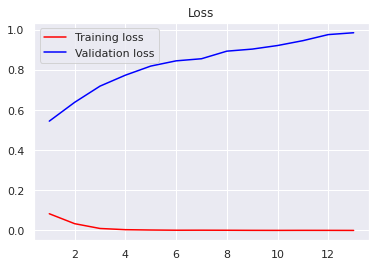

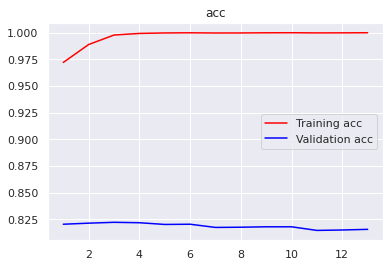

In [19]:
import matplotlib.pyplot as plt
val_loss = history.history['val_loss']
loss = history.history['loss']
epochs = range(1, len(loss ) + 1)
plt.title('Loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()
plt.show()

plt.cla()
val_loss = history.history['val_acc']
loss = history.history['acc']
epochs = range(1, len(loss ) + 1)
 
plt.title('acc')
plt.plot(epochs, loss, 'red', label='Training acc')
plt.plot(epochs, val_loss, 'blue', label='Validation acc')
plt.legend()
plt.show()

[[2111  432]
 [ 457 2000]]
              precision    recall  f1-score   support

           0     0.8220    0.8301    0.8261      2543
           1     0.8224    0.8140    0.8182      2457

    accuracy                         0.8222      5000
   macro avg     0.8222    0.8221    0.8221      5000
weighted avg     0.8222    0.8222    0.8222      5000



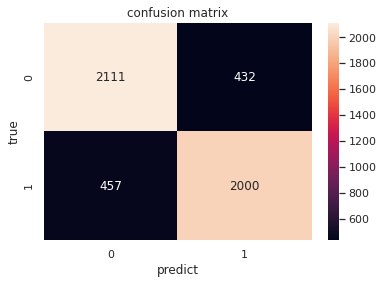

In [20]:
model.load_weights("model/textcnn.hdf5")
def 给测试集输出指标(val_data,test_y):
    testpre=model.predict([val_data])
    ypre=np.argmax(testpre,axis=1)
    ytrue=np.argmax(test_y,axis=1)


    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report
    def 混淆矩阵(valp,valy):
        sns.set()
        np.set_printoptions(suppress=True)
        f,ax=plt.subplots()
        valp=np.array(valp)
        valy=np.array(valy)
        C2= confusion_matrix(valy , valp, labels=list(range(len(set(df["category"])))))
        print(C2) #打印出来看看
        sns.heatmap(C2,annot=True,ax=ax,fmt='.20g') #画热力图

        ax.set_title('confusion matrix') #标题
        ax.set_xlabel('predict') #x轴
        ax.set_ylabel('true') #y轴

    def 评价指标(val_data,val_y):
        混淆矩阵(val_data,val_y)
        print(classification_report(val_y,val_data,digits=4))
    评价指标(ypre,ytrue)
给测试集输出指标(val_data,val_y)

In [17]:
model.load_weights("model/textcnn.hdf5")
test_text = ["The acting was simply amazing, what else could you say. What could be more appealing to people(even today) than watching actors like Al Pacino, Marlon Brando, James Caan, Diane Keaton, Talia Shire and Robert Duvall. This is like heaven for someone who is a fan of movies. With this movie Brando was able to bring himself back into the limelight. His performance as the godfather alone is iconic. His character has been recreated so much in films that it has almost if it has not already become a cliché. His performance though was not a cliché. His performance was subtle and breathtaking. It was so genuine and realistic that it was not just probably but definitely more genuine than Marlon Brando himself. Al Pacino was perfect for this film as well. What a way to start up your career. His character was all about depth and he displayed it perfectly. He was able to display his own inner-battles in his mind as well as the battles he had with his family, friends and enemies. His character was more of a psychological character study than anything else to me. Robert Duvall to me was the glue to the movie. He added a different perspective to everything in just that he was not Italian yet having the respect of the mafia. His character is a man of high authority within the Corleone family who was listened to and insightful;. This was simply perfect giving the film great balance throughout. The rest of the cast was just icing on the cake."]
test_text = ["I hate this film"]

test_sequence = tokenizer.texts_to_sequences(test_text)
test_pad = pad_sequences(test_sequence, maxlen=MAX_SEQUENCE_LENGTH)
predictions = model.predict(test_pad)
predictions

#a = [[int(i)] for i in val_data[222]]
#print(tokenizer.sequences_to_texts(a))
#print(predictions[222])

array([[0.1853644, 0.8146356]], dtype=float32)